### HyperParameter for LightBGM Model: -
A few important parameters and their usage is listed below : 

- max_depth : It sets a limit on the depth of tree. The default value is 20. It is effective in controlling over fitting.
- categorical_feature : It specifies the categorical feature used for training model.
- bagging_fraction : It specifies the fraction of data to be considered for each iteration.
- num_iterations : It specifies the number of iterations to be performed. The default value is 100.
- num_leaves : It specifies the number of leaves in a tree. It should be smaller than the square of max_depth.
- max_bin : It specifies the maximum number of bins to bucket the feature values.
- min_data_in_bin : It specifies the minimum amount of data in one bin.
- task : It specifies the task we wish to perform which is either train or prediction. The default entry is train. Another possible value for this parameter is prediction.
- feature_fraction : It specifies the fraction of features to be considered in each iteration. The default value is one.

### Importing Required Libraries

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from datetime import timedelta
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error as msle

In [2]:
# read the final data set with the newly created features
data = pd.read_csv('Data/final_data.csv')

In [3]:
# top rows of the data
data.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
2,2009-01-14,367,1111085319,1.88,0,0,14,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
3,2009-01-14,367,1111085345,1.88,0,0,29,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
4,2009-01-14,367,1111085350,1.98,0,0,35,1,0,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [4]:
# convert the WEEK_END_DATE to datetime format
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [5]:
# we will drop the 2 date columns,  2_MONTH_BEFORE and 1_WEEK_BEFORE as they are not required now.
data = data.drop(columns=['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [6]:
# check for the null values
data.isna().sum().sum()

0

In [7]:
# create an array of unique week dates
week = data.WEEK_END_DATE.unique()

In [8]:

def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [9]:
# we will use the same combination of 2 month training data with 14 validation sets
validation_df(data, week, no_of_months=2, no_of_validation= 14)

,train_shape,validation_shape,test_shape,train_start,train_end,validate_week,test_week,no_days_train,set_no
0,13089,1640,1642,2011-07-13,2011-08-31,2011-09-14,2011-09-28,56 days,set1
1,13102,1632,1638,2011-07-06,2011-08-24,2011-09-07,2011-09-21,56 days,set2
2,13101,1629,1640,2011-06-29,2011-08-17,2011-08-31,2011-09-14,56 days,set3
3,13101,1640,1632,2011-06-22,2011-08-10,2011-08-24,2011-09-07,56 days,set4
4,13109,1638,1629,2011-06-15,2011-08-03,2011-08-17,2011-08-31,56 days,set5
5,13108,1631,1640,2011-06-08,2011-07-27,2011-08-10,2011-08-24,56 days,set6
6,13108,1640,1638,2011-06-01,2011-07-20,2011-08-03,2011-08-17,56 days,set7
7,13112,1637,1631,2011-05-25,2011-07-13,2011-07-27,2011-08-10,56 days,set8
8,13104,1635,1640,2011-05-18,2011-07-06,2011-07-20,2011-08-03,56 days,set9
9,13101,1639,1637,2011-05-11,2011-06-29,2011-07-13,2011-07-27,56 days,set10


In [10]:
# train validation set
def get_evaluation_sets(df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['validate_week'])
        # get the train data
        train_data = data[(data.WEEK_END_DATE >= df.loc[row]['train_start']) & (data.WEEK_END_DATE <= df.loc[row]['train_end'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

In [11]:
# store the train and validation sets in a list
evaluation_set = get_evaluation_sets(validation_df(data, week, no_of_months=2, no_of_validation=14))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00
2011-07-13 00:00:00
2011-07-06 00:00:00
2011-06-29 00:00:00
2011-06-22 00:00:00
2011-06-15 00:00:00


In [98]:
# function to calculate the RMSLE
def lgbm_rmsle(y_true ,y_pred):
    score = np.sqrt(msle(y_true, y_pred))
    return 'rmsle',score, False

### Parameter1: - N_ESTIMATORS

In [74]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in (range(min_r, max_r, 20)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            
            # define the XGBRegressor Model 
            model = lgb.LGBMRegressor(n_estimators = n_est,
                                     learning_rate = 0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='regression')
            # fit the model
            model.fit(train_data_x, train_data_y ,eval_metric= lgbm_rmsle, eval_set= e_set, verbose=False)
            
            #print('model.evals_result_: ', model.evals_result_)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With N_ESTIMATORS:\t'+ str(n_est) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train) + "\tMEAN RMSLE VALID: "+str(mean_score_valid))
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
        #accuracy = model.score(train_data_x, train_data_y)
        #print(accuracy)

    return pd.DataFrame.from_dict(results)

In [83]:
n_estimators_result = get_n_estimators(evaluation_set,min_r = 200, max_r = 501)

With N_ESTIMATORS:	200	MEAN RMSLE TRAIN:	0.4983133024952022	MEAN RMSLE VALID: 0.5407333639758173
With N_ESTIMATORS:	220	MEAN RMSLE TRAIN:	0.4805417246438922	MEAN RMSLE VALID: 0.5265413198398577
With N_ESTIMATORS:	240	MEAN RMSLE TRAIN:	0.46542293674615426	MEAN RMSLE VALID: 0.5153534996317725
With N_ESTIMATORS:	260	MEAN RMSLE TRAIN:	0.4527527688838724	MEAN RMSLE VALID: 0.5061281216850778
With N_ESTIMATORS:	280	MEAN RMSLE TRAIN:	0.4423597024248374	MEAN RMSLE VALID: 0.49893727728749226
With N_ESTIMATORS:	300	MEAN RMSLE TRAIN:	0.4337929882979138	MEAN RMSLE VALID: 0.4934783375920003
With N_ESTIMATORS:	320	MEAN RMSLE TRAIN:	0.42648395068354844	MEAN RMSLE VALID: 0.4890100124997697
With N_ESTIMATORS:	340	MEAN RMSLE TRAIN:	0.4201756139102974	MEAN RMSLE VALID: 0.4849592335081741
With N_ESTIMATORS:	360	MEAN RMSLE TRAIN:	0.4147490423435412	MEAN RMSLE VALID: 0.48145534590771255
With N_ESTIMATORS:	380	MEAN RMSLE TRAIN:	0.4100489569875276	MEAN RMSLE VALID: 0.47861053494352374
With N_ESTIMATORS:	400	ME

In [84]:
n_estimators_result.columns

Index(['n_estimators', 'mean_rmsle_train', 'mean_rmsle_valid'], dtype='object')

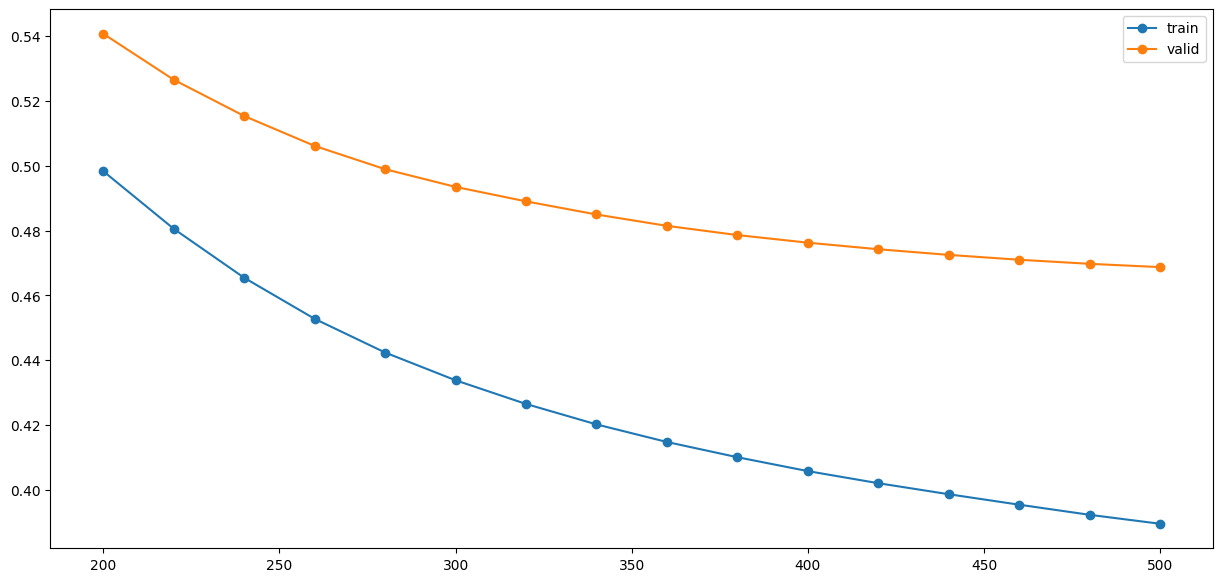

In [86]:
plt.figure(figsize=(15,7))
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_train'],label='train',marker='o');
plt.plot(n_estimators_result['n_estimators'], n_estimators_result['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

- We can see that RMSLE is continuosly improving but after 500 the target variable value becomes negative
- So, chossing n_estimators value as 500.

### Parameter 2: - MAX_DEPTH

In [100]:
def get_max_depth(evaluation_set):
    
    results = []
    
    for depth in (range(2, 5, 1)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for train, valid in (evaluation_set):
                        
            # seperate the independent and target variable from the train and validation set    
            train_data_x = train.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']

            valid_data_x = valid.drop(columns= ['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']
            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y),(valid_data_x, valid_data_y)]

            # fit the model keeping the n_estimator value fixed 720
            model = lgb.LGBMRegressor(n_estimators = 500,
                                     max_depth=depth,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='regression')
            model.fit(train_data_x, train_data_y, eval_metric= lgbm_rmsle ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['training']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['valid_1']['rmsle'][-1])
            
        # calculate the mean rmsle on train and valid   
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
    
        print('With DEPTH:\t'+ str(depth) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+ '\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['depth']= depth
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame.from_dict(results)

In [101]:
max_depth_results = get_max_depth(evaluation_set)

With DEPTH:	2	MEAN RMSLE TRAIN:	0.49192829347862255	MEAN RMSLE VALID: 0.5237454935695756
With DEPTH:	3	MEAN RMSLE TRAIN:	0.4451490098978607	MEAN RMSLE VALID: 0.4850284830181775
With DEPTH:	4	MEAN RMSLE TRAIN:	0.4163296370454783	MEAN RMSLE VALID: 0.4677921612259338


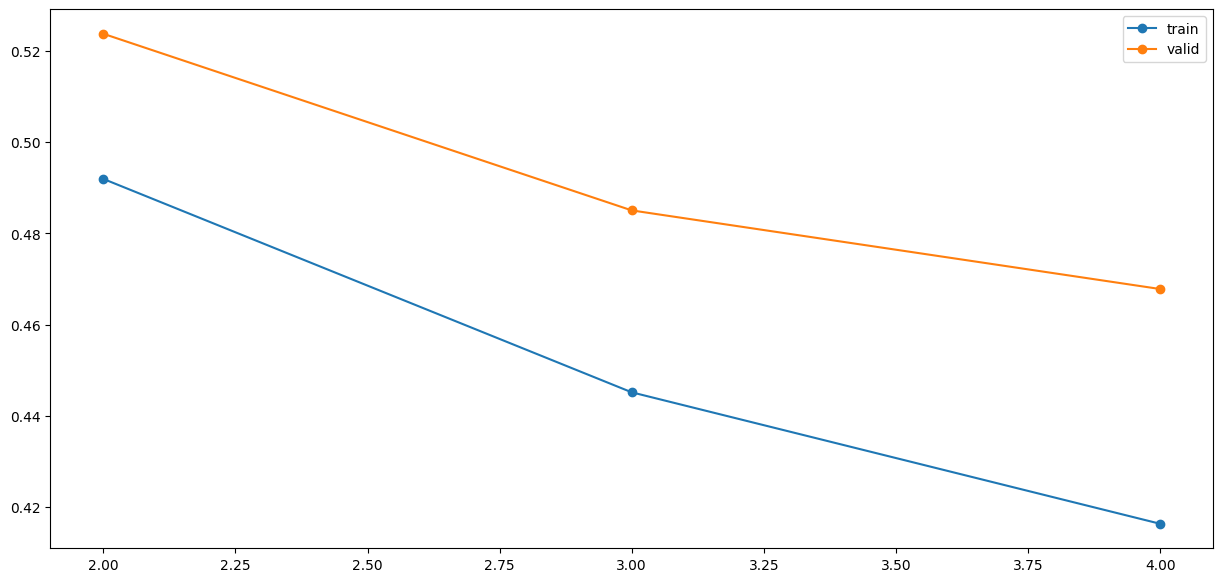

In [102]:
plt.figure(figsize=(15,7))
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

- Max_depth will be 4 as  the target variable value becomes negative.
- num_leaves - It should be smaller than the square of max_depth. - Since 4 is max_depth so num_leaves will be 2.

---

### `Final Hyperparameters`


- **`N_ESTIMATORS`** :  500
- **`MAX_DEPTH`** :  4
- **`LEARNING RATE`** : 0.01
- **`NUM_LEAVES`** : 2

---